## ICU Length of stay using LightGBM Model and Tranformer Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv


In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [6]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [7]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [8]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [9]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [10]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [11]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [12]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [13]:
# Careplan

careplan_df = pd.read_csv("100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [14]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [15]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [16]:
#Conditions

conditions_df = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [17]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [18]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [19]:
medications_df = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [20]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [21]:
#Observations

observations_df = pd.read_csv("100k_synthea_covid19_csv/observations.csv").sample(frac = 0.1)
observations_df_test = pd.read_csv("10k_synthea_covid19_csv/observations.csv").sample(frac = 0.1)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:75]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [22]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [23]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [24]:
observations_df.head()

,patient,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Respiratory_rate,patient's_observation_of_Body_Weight,patient's_observation_of_Heart_rate,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Glomerular_filtration_rate173_sq_Mpredicted,...,patient's_observation_of_Sodium,patient's_observation_of_Carbon_Dioxide,patient's_observation_of_Oxygen_Partial_pressure_in_Arterial_blood,patient's_observation_of_High_Density_Lipoprotein_Cholesterol,patient's_observation_of_Low_Density_Lipoprotein_Cholesterol,patient's_observation_of_Total_Cholesterol,patient's_observation_of_Triglycerides,patient's most seen observation,patient_obs_count,patient_obs_count_unique
2831625,6dc044b5-68dc-4c6b-bbe4-85d017cf0b93,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Sodium_Molesvolume_in_Serum_or_Plasma,73,42
14262810,85ddeeb0-ed5d-454e-90b7-f40a65e89477,0,0,0,80.4,0,0,0,0,0,...,0,0,0,0,0,0,0,Alanine_aminotransferase_Enzymatic_activityvol...,63,42
10139807,da82d1ac-2ac2-4906-86be-e1534d5d4474,0,0,0,0,0,0,0,5.6,0,...,0,0,0,0,0,0,0,Albumin_Massvolume_in_Serum_or_Plasma,114,45
9832772,fe293a8c-ca7c-4338-8e2d-1f5fe42e378c,0,132.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Creatinine,3,3
4959876,9389379a-b386-4fa9-a65c-d9d0f6252bc5,0,0,13.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Heart_rate,5,5


In [25]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [26]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [27]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [28]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [29]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [30]:
encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [31]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [32]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [33]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [34]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [35]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [36]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [37]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [38]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [40]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [41]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [42]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
for i in cats:
  data[i] = data[i].astype(str)
  data[i].fillna(0, inplace = True)

In [43]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 1314 unique patients.


In [44]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [45]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


### Let's create our target feature, careplan duration


In [46]:
y = df['duration']
LABEL = "duration"

In [47]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [48]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [49]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [50]:
NUMERIC_FEATURES = ['healthcare_coverage_ratio',
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Sore throat symptom finding",
 "patient's_condition_of_Headache finding",
 "patient's_condition_of_Chill finding",
 "patient's_condition_of_Diabetes",
 'patient_condition_count',
 'patient_condition_unique',
 'patient_obs_count',
 'patient_obs_count_unique',
 'total_med_duration_of_patient',
 'total_med_cost_of_patient',
 'total_med_count_of_patient',
 'total_unique_med_of_patient',
 'used_unique_device_per_patient',
 'Mechanical ventilator (physical object)',
 'unique_immunizations',
 "patient's Digital Radiographycount",
 "patient's Ultrasoundcount",
 "patient's_different_bodysite_imaging_studies",
 'unique_allergies_per_patient']

In [51]:
CATEGORICAL_FEATURES = ["patient's most seen condition",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Alkaline_phosphatase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Calcium_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's most seen observation",
 "patient's most used medication",
 "patient's most usage reason",
 "patient's most used device",
 "patient's most seen allergy",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count"]

In [52]:
for i in list(df.select_dtypes(['object']).columns):
  df[i].fillna(0, inplace = True)
  df[i] = df[i].astype("category")
for i in NUMERIC_FEATURES:
  df[i].fillna(0, inplace = True)

### About real distributions of hospital durations?

### FT - Transformer Models

In [53]:
#!pip install tensorflow_addons

In [54]:
#!pip install tabtransformertf


In [55]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

2023-01-25 10:06:57.194174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [56]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [57]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [58]:
y = data['duration']
LABEL = "duration"

In [59]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [60]:
FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)

In [61]:
for i in CATEGORICAL_FEATURES:
  train_data[i] = train_data[i].astype(str)
  train_data[i].fillna(0, inplace = True)
  test_data[i] = test_data[i].astype(str)
  test_data[i].fillna(0, inplace = True)


In [62]:
train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [63]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2, random_state = 42)

Text(0.5, 1.0, 'Distributions of duration in each dataset')

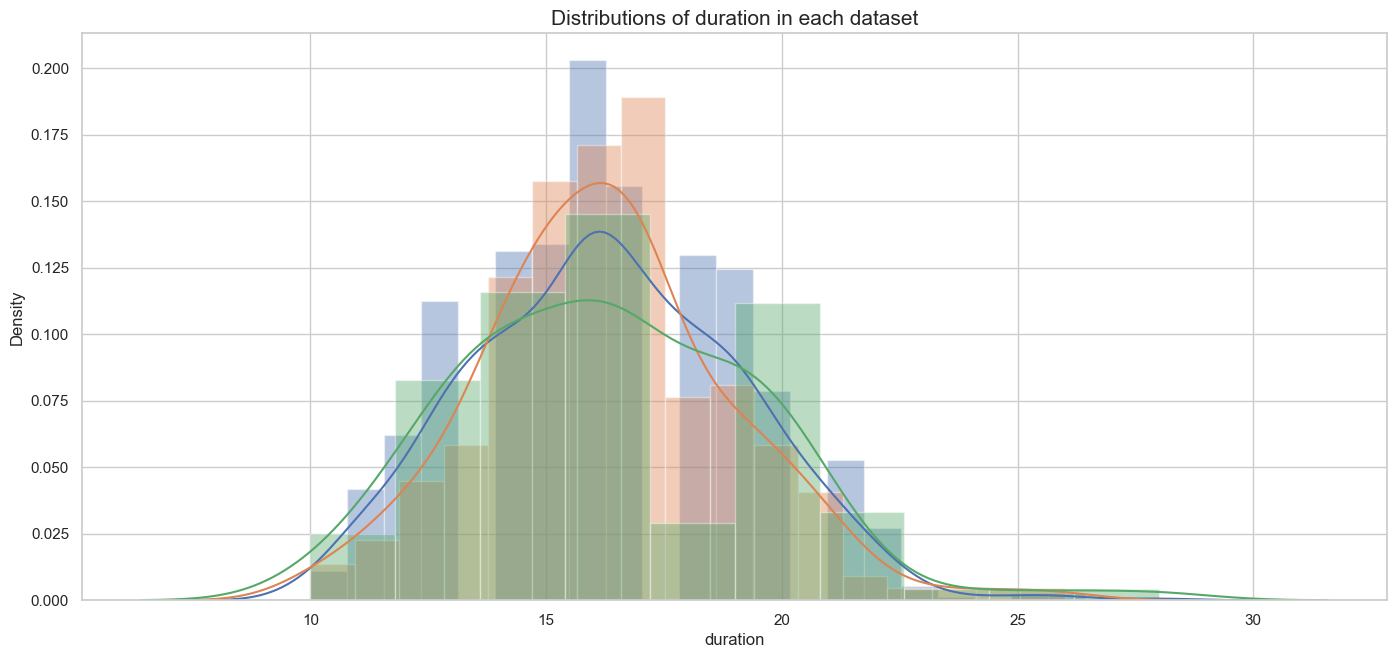

In [64]:
plt.figure(figsize = (15,7))
sns.distplot(X_train[LABEL])
sns.distplot(X_val[LABEL])
sns.distplot(test_data[LABEL])
plt.title("Distributions of duration in each dataset", fontsize = 15)

In [65]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [66]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

2023-01-25 10:07:02.206486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [67]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    #numerical_bins=32,
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 100

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/100
2/2 [==============================] - 9s 2s/step - loss: 263.7132 - output_loss: 263.7132 - output_rmse: 16.2392 - val_loss: 206.8391 - val_output_loss: 206.8391 - val_output_rmse: 14.3819
Epoch 2/100
2/2 [==============================] - 3s 1s/step - loss: 217.0046 - output_loss: 217.0046 - output_rmse: 14.7311 - val_loss: 186.8060 - val_output_loss: 186.8060 - val_output_rmse: 13.6677
Epoch 3/100
2/2 [==============================] - 3s 1s/step - loss: 193.6499 - output_loss: 193.6499 - output_rmse: 13.9158 - val_loss: 174.7350 - val_output_loss: 174.7350 - val_output_rmse: 13.2187
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 179.1404 - output_loss: 179.1404 - output_rmse: 13.3843 - val_loss: 163.6643 - val_output_loss: 163.6643 - val_output_rmse: 12.7931
Epoch 5/100
2/2 [==============================] - 3s 1s/step - loss: 167.5368 - output_loss: 167.5368 - output_rmse: 12.9436 - val_loss: 154.9885 - val_output_loss: 154.9885 - val_output_rmse

In [68]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=32,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 100

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/100
2/2 [==============================] - 6s 1s/step - loss: 268.2117 - output_loss: 268.2117 - output_rmse: 16.3772 - val_loss: 228.4029 - val_output_loss: 228.4029 - val_output_rmse: 15.1130
Epoch 2/100
2/2 [==============================] - 2s 736ms/step - loss: 240.7328 - output_loss: 240.7328 - output_rmse: 15.5156 - val_loss: 198.9204 - val_output_loss: 198.9204 - val_output_rmse: 14.1039
Epoch 3/100
2/2 [==============================] - 2s 723ms/step - loss: 212.1531 - output_loss: 212.1531 - output_rmse: 14.5655 - val_loss: 170.0618 - val_output_loss: 170.0618 - val_output_rmse: 13.0408
Epoch 4/100
2/2 [==============================] - 1s 721ms/step - loss: 185.9998 - output_loss: 185.9998 - output_rmse: 13.6382 - val_loss: 152.8161 - val_output_loss: 152.8161 - val_output_rmse: 12.3619
Epoch 5/100
2/2 [==============================] - 2s 727ms/step - loss: 165.7852 - output_loss: 165.7852 - output_rmse: 12.8758 - val_loss: 139.9727 - val_output_loss: 139.9727 - val

In [69]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 657ms/step


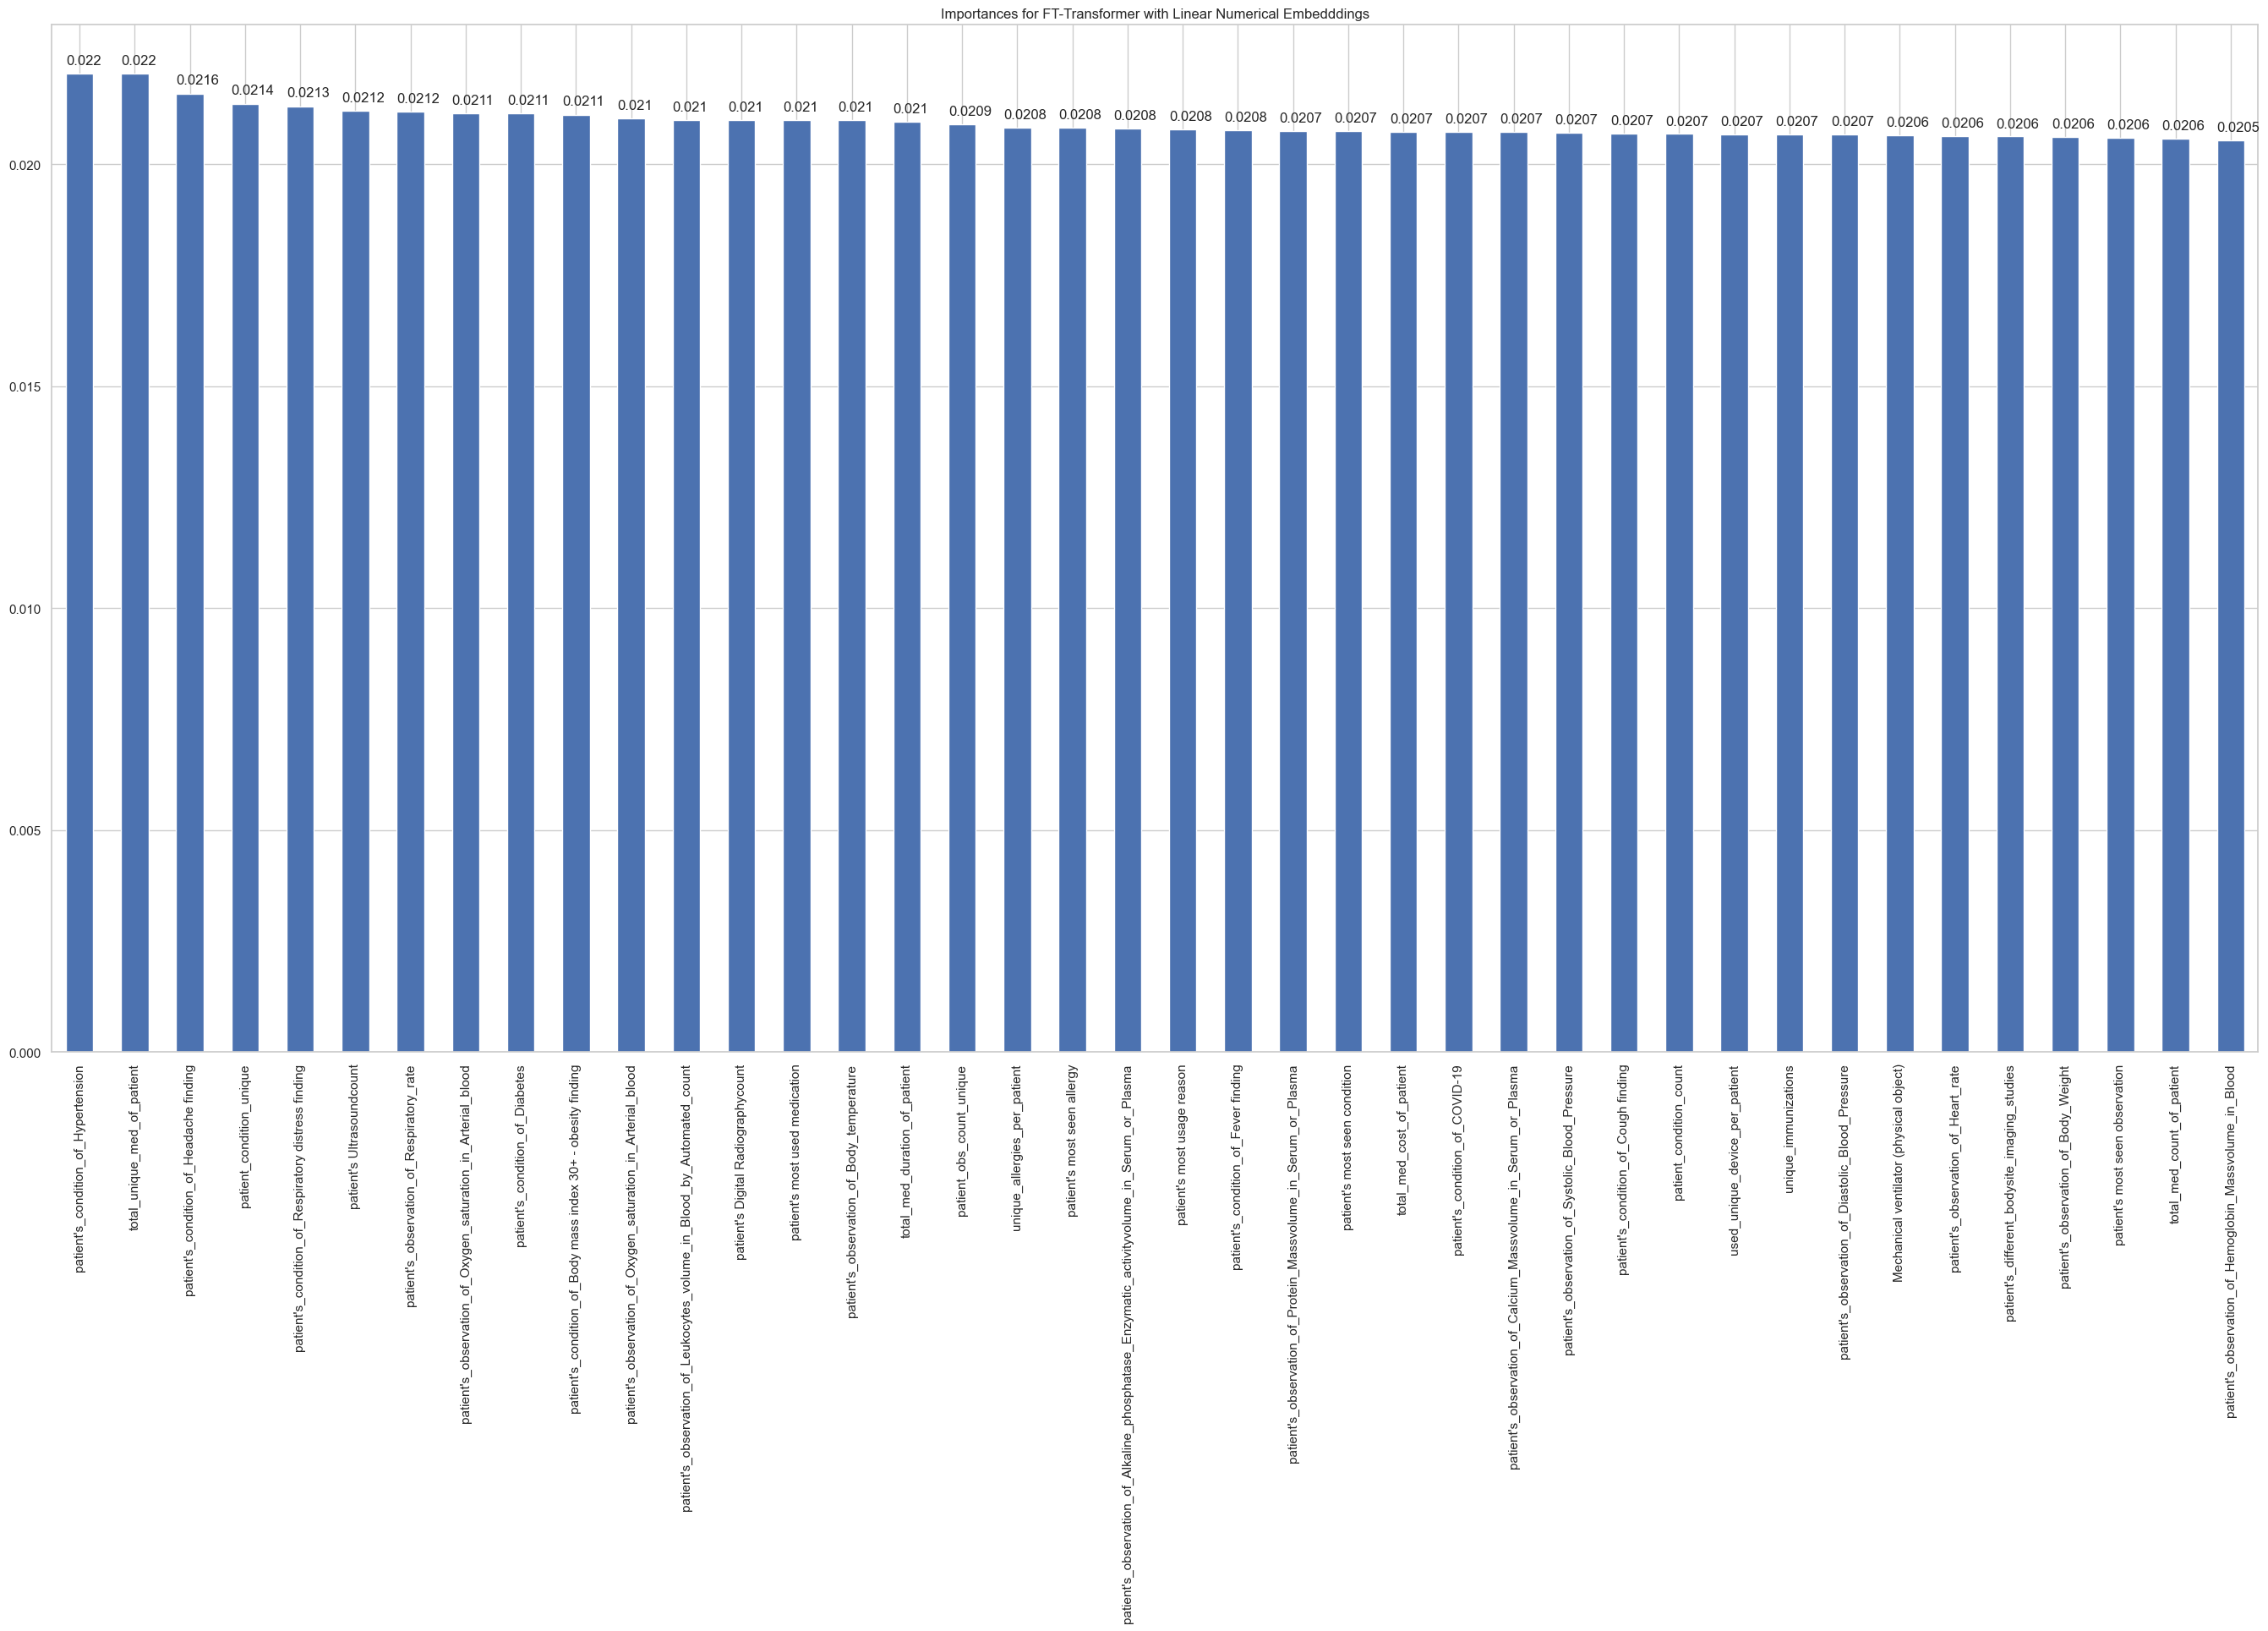

In [70]:
# Utility function
def get_model_importances(importances, title="Importances"):
    imps_sorted = importances.mean().sort_values(ascending=False)
    imps_sorted2 = imps_sorted.copy()[:40]
    
    plt.figure(figsize=(30,15))
    ax = imps_sorted2.plot.bar()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), 4)), (p.get_x(), p.get_height() * 1.01))
    plt.title(title)
    plt.show()
    
    return imps_sorted

# Model output
linear_importances = linear_test_preds['importances']

# Exclude attention from CLS token to CLS token
linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)

# Plot and store
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)

In [71]:
print("With those features, we got RMSE of (LINEAR):", linear_rms)

With those features, we got RMSE of (LINEAR): 3.1718208681884152


In [72]:
print("With those features, we got RMSE of (PERIODIC):", periodic_rms)


With those features, we got RMSE of (PERIODIC): 3.1713494173395986


In [73]:
#pip install optuna

### Parameter Optimization for Transformer Models

In [74]:
#### Linear Encoding

In [75]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-25 10:13:38,018] A new study created in memory with name: no-name-4c350326-f49d-4e60-8b32-cc330689dc44


Epoch 1/150
2/2 [==============================] - 9s 2s/step - loss: 253.1667 - output_loss: 253.1667 - output_rmse: 15.9112 - val_loss: 199.0234 - val_output_loss: 199.0234 - val_output_rmse: 14.1076
Epoch 2/150
2/2 [==============================] - 2s 845ms/step - loss: 211.7503 - output_loss: 211.7503 - output_rmse: 14.5516 - val_loss: 166.1652 - val_output_loss: 166.1652 - val_output_rmse: 12.8905
Epoch 3/150
2/2 [==============================] - 2s 844ms/step - loss: 183.3650 - output_loss: 183.3650 - output_rmse: 13.5412 - val_loss: 145.6709 - val_output_loss: 145.6709 - val_output_rmse: 12.0694
Epoch 4/150
2/2 [==============================] - 2s 834ms/step - loss: 161.5175 - output_loss: 161.5175 - output_rmse: 12.7090 - val_loss: 130.7108 - val_output_loss: 130.7108 - val_output_rmse: 11.4329
Epoch 5/150
2/2 [==============================] - 2s 842ms/step - loss: 144.5097 - output_loss: 144.5097 - output_rmse: 12.0212 - val_loss: 118.3033 - val_output_loss: 118.3033 - val

[I 2023-01-25 10:15:48,302] Trial 0 finished with value: 3.1706630763139576 and parameters: {'numerical_bins': 109, 'embedding_dim': 29, 'depth': 5, 'heads': 4, 'attn_dropout': 0.20703275418787165, 'ff_dropout': 0.3887556674971705}. Best is trial 0 with value: 3.1706630763139576.


Epoch 1/150
2/2 [==============================] - 4s 567ms/step - loss: 267.6341 - output_loss: 267.6341 - output_rmse: 16.3595 - val_loss: 258.6783 - val_output_loss: 258.6783 - val_output_rmse: 16.0835
Epoch 2/150
2/2 [==============================] - 0s 112ms/step - loss: 259.6841 - output_loss: 259.6841 - output_rmse: 16.1147 - val_loss: 251.4641 - val_output_loss: 251.4641 - val_output_rmse: 15.8576
Epoch 3/150
2/2 [==============================] - 0s 111ms/step - loss: 252.7412 - output_loss: 252.7412 - output_rmse: 15.8978 - val_loss: 239.5910 - val_output_loss: 239.5910 - val_output_rmse: 15.4787
Epoch 4/150
2/2 [==============================] - 0s 109ms/step - loss: 241.9531 - output_loss: 241.9531 - output_rmse: 15.5548 - val_loss: 226.7385 - val_output_loss: 226.7385 - val_output_rmse: 15.0578
Epoch 5/150
2/2 [==============================] - 0s 110ms/step - loss: 229.7493 - output_loss: 229.7493 - output_rmse: 15.1575 - val_loss: 218.3430 - val_output_loss: 218.3430 - 

[I 2023-01-25 10:16:16,238] Trial 1 finished with value: 3.171880882257367 and parameters: {'numerical_bins': 20, 'embedding_dim': 20, 'depth': 1, 'heads': 3, 'attn_dropout': 0.28787996343939437, 'ff_dropout': 0.14259860097743648}. Best is trial 0 with value: 3.1706630763139576.


Epoch 1/150
2/2 [==============================] - 6s 1s/step - loss: 267.9406 - output_loss: 267.9406 - output_rmse: 16.3689 - val_loss: 199.2594 - val_output_loss: 199.2594 - val_output_rmse: 14.1159
Epoch 2/150
2/2 [==============================] - 1s 512ms/step - loss: 233.3590 - output_loss: 233.3590 - output_rmse: 15.2761 - val_loss: 179.7083 - val_output_loss: 179.7083 - val_output_rmse: 13.4055
Epoch 3/150
2/2 [==============================] - 1s 505ms/step - loss: 203.8577 - output_loss: 203.8577 - output_rmse: 14.2779 - val_loss: 159.3507 - val_output_loss: 159.3507 - val_output_rmse: 12.6234
Epoch 4/150
2/2 [==============================] - 1s 516ms/step - loss: 179.9357 - output_loss: 179.9357 - output_rmse: 13.4140 - val_loss: 139.3693 - val_output_loss: 139.3693 - val_output_rmse: 11.8055
Epoch 5/150
2/2 [==============================] - 1s 520ms/step - loss: 159.7044 - output_loss: 159.7044 - output_rmse: 12.6374 - val_loss: 123.5453 - val_output_loss: 123.5453 - val

[I 2023-01-25 10:17:41,258] Trial 2 finished with value: 3.171067058988079 and parameters: {'numerical_bins': 180, 'embedding_dim': 39, 'depth': 3, 'heads': 3, 'attn_dropout': 0.310021675822309, 'ff_dropout': 0.2990409765267971}. Best is trial 0 with value: 3.1706630763139576.


Epoch 1/150
2/2 [==============================] - 7s 2s/step - loss: 183.0194 - output_loss: 183.0194 - output_rmse: 13.5285 - val_loss: 81.6429 - val_output_loss: 81.6429 - val_output_rmse: 9.0356
Epoch 2/150
2/2 [==============================] - 2s 977ms/step - loss: 88.1704 - output_loss: 88.1704 - output_rmse: 9.3899 - val_loss: 46.2682 - val_output_loss: 46.2682 - val_output_rmse: 6.8021
Epoch 3/150
2/2 [==============================] - 2s 976ms/step - loss: 53.2954 - output_loss: 53.2954 - output_rmse: 7.3004 - val_loss: 28.5991 - val_output_loss: 28.5991 - val_output_rmse: 5.3478
Epoch 4/150
2/2 [==============================] - 2s 978ms/step - loss: 33.8957 - output_loss: 33.8957 - output_rmse: 5.8220 - val_loss: 17.6903 - val_output_loss: 17.6903 - val_output_rmse: 4.2060
Epoch 5/150
2/2 [==============================] - 2s 982ms/step - loss: 21.5760 - output_loss: 21.5760 - output_rmse: 4.6450 - val_loss: 12.4834 - val_output_loss: 12.4834 - val_output_rmse: 3.5332
Epoch

[I 2023-01-25 10:21:02,178] Trial 3 finished with value: 2.5113521438308193 and parameters: {'numerical_bins': 124, 'embedding_dim': 83, 'depth': 3, 'heads': 3, 'attn_dropout': 0.16409944121304643, 'ff_dropout': 0.1666258977501454}. Best is trial 3 with value: 2.5113521438308193.


Epoch 1/150
2/2 [==============================] - 17s 5s/step - loss: 238.5245 - output_loss: 238.5245 - output_rmse: 15.4442 - val_loss: 129.7465 - val_output_loss: 129.7465 - val_output_rmse: 11.3906
Epoch 2/150
2/2 [==============================] - 9s 4s/step - loss: 128.0748 - output_loss: 128.0748 - output_rmse: 11.3170 - val_loss: 86.1814 - val_output_loss: 86.1814 - val_output_rmse: 9.2834
Epoch 3/150
2/2 [==============================] - 8s 4s/step - loss: 89.2136 - output_loss: 89.2136 - output_rmse: 9.4453 - val_loss: 69.0163 - val_output_loss: 69.0163 - val_output_rmse: 8.3076
Epoch 4/150
2/2 [==============================] - 9s 4s/step - loss: 72.5429 - output_loss: 72.5429 - output_rmse: 8.5172 - val_loss: 61.7113 - val_output_loss: 61.7113 - val_output_rmse: 7.8557
Epoch 5/150
2/2 [==============================] - 9s 4s/step - loss: 64.4286 - output_loss: 64.4286 - output_rmse: 8.0267 - val_loss: 55.1673 - val_output_loss: 55.1673 - val_output_rmse: 7.4275
Epoch 6/15

[I 2023-01-25 10:31:07,449] Trial 4 finished with value: 3.1711143902613865 and parameters: {'numerical_bins': 69, 'embedding_dim': 87, 'depth': 6, 'heads': 6, 'attn_dropout': 0.26787786660213564, 'ff_dropout': 0.14067769978687789}. Best is trial 3 with value: 2.5113521438308193.


Epoch 1/150
2/2 [==============================] - 6s 2s/step - loss: 213.3658 - output_loss: 213.3658 - output_rmse: 14.6070 - val_loss: 99.6149 - val_output_loss: 99.6149 - val_output_rmse: 9.9807
Epoch 2/150
2/2 [==============================] - 2s 975ms/step - loss: 111.9069 - output_loss: 111.9069 - output_rmse: 10.5786 - val_loss: 50.0943 - val_output_loss: 50.0943 - val_output_rmse: 7.0777
Epoch 3/150
2/2 [==============================] - 2s 963ms/step - loss: 68.1387 - output_loss: 68.1387 - output_rmse: 8.2546 - val_loss: 29.0046 - val_output_loss: 29.0046 - val_output_rmse: 5.3856
Epoch 4/150
2/2 [==============================] - 2s 979ms/step - loss: 40.7178 - output_loss: 40.7178 - output_rmse: 6.3811 - val_loss: 19.7515 - val_output_loss: 19.7515 - val_output_rmse: 4.4443
Epoch 5/150
2/2 [==============================] - 2s 1s/step - loss: 26.3789 - output_loss: 26.3789 - output_rmse: 5.1360 - val_loss: 15.4318 - val_output_loss: 15.4318 - val_output_rmse: 3.9283
Epoch

[I 2023-01-25 10:34:58,838] Trial 5 finished with value: 2.2220303986329775 and parameters: {'numerical_bins': 116, 'embedding_dim': 81, 'depth': 2, 'heads': 5, 'attn_dropout': 0.26715375923139556, 'ff_dropout': 0.2643967610647984}. Best is trial 5 with value: 2.2220303986329775.


Epoch 1/150
2/2 [==============================] - 5s 1s/step - loss: 231.3145 - output_loss: 231.3145 - output_rmse: 15.2090 - val_loss: 157.3926 - val_output_loss: 157.3926 - val_output_rmse: 12.5456
Epoch 2/150
2/2 [==============================] - 1s 458ms/step - loss: 168.5818 - output_loss: 168.5818 - output_rmse: 12.9839 - val_loss: 134.3882 - val_output_loss: 134.3882 - val_output_rmse: 11.5926
Epoch 3/150
2/2 [==============================] - 1s 447ms/step - loss: 146.1981 - output_loss: 146.1981 - output_rmse: 12.0912 - val_loss: 120.8229 - val_output_loss: 120.8229 - val_output_rmse: 10.9919
Epoch 4/150
2/2 [==============================] - 1s 450ms/step - loss: 131.4885 - output_loss: 131.4885 - output_rmse: 11.4668 - val_loss: 110.2780 - val_output_loss: 110.2780 - val_output_rmse: 10.5013
Epoch 5/150
2/2 [==============================] - 1s 457ms/step - loss: 119.9243 - output_loss: 119.9243 - output_rmse: 10.9510 - val_loss: 100.8699 - val_output_loss: 100.8699 - val

[I 2023-01-25 10:36:06,096] Trial 6 finished with value: 3.1711435257369756 and parameters: {'numerical_bins': 104, 'embedding_dim': 43, 'depth': 2, 'heads': 4, 'attn_dropout': 0.11389550955626176, 'ff_dropout': 0.1980116798149683}. Best is trial 5 with value: 2.2220303986329775.


Epoch 1/150
2/2 [==============================] - 9s 2s/step - loss: 236.2008 - output_loss: 236.2008 - output_rmse: 15.3688 - val_loss: 120.1191 - val_output_loss: 120.1191 - val_output_rmse: 10.9599
Epoch 2/150
2/2 [==============================] - 3s 2s/step - loss: 143.4402 - output_loss: 143.4402 - output_rmse: 11.9767 - val_loss: 85.8299 - val_output_loss: 85.8299 - val_output_rmse: 9.2644
Epoch 3/150
2/2 [==============================] - 3s 2s/step - loss: 102.0290 - output_loss: 102.0290 - output_rmse: 10.1009 - val_loss: 69.0652 - val_output_loss: 69.0652 - val_output_rmse: 8.3106
Epoch 4/150
2/2 [==============================] - 3s 1s/step - loss: 78.3569 - output_loss: 78.3569 - output_rmse: 8.8519 - val_loss: 58.7251 - val_output_loss: 58.7251 - val_output_rmse: 7.6632
Epoch 5/150
2/2 [==============================] - 3s 2s/step - loss: 64.3763 - output_loss: 64.3763 - output_rmse: 8.0235 - val_loss: 51.3947 - val_output_loss: 51.3947 - val_output_rmse: 7.1690
Epoch 6/

[I 2023-01-25 10:38:42,031] Trial 7 finished with value: 3.1714953453383337 and parameters: {'numerical_bins': 22, 'embedding_dim': 77, 'depth': 4, 'heads': 4, 'attn_dropout': 0.1382167949339258, 'ff_dropout': 0.35932687603008423}. Best is trial 5 with value: 2.2220303986329775.


Epoch 1/150
2/2 [==============================] - 16s 5s/step - loss: 223.8572 - output_loss: 223.8572 - output_rmse: 14.9619 - val_loss: 112.3125 - val_output_loss: 112.3125 - val_output_rmse: 10.5978
Epoch 2/150
2/2 [==============================] - 8s 4s/step - loss: 115.3840 - output_loss: 115.3840 - output_rmse: 10.7417 - val_loss: 82.7391 - val_output_loss: 82.7391 - val_output_rmse: 9.0961
Epoch 3/150
2/2 [==============================] - 8s 4s/step - loss: 86.7560 - output_loss: 86.7560 - output_rmse: 9.3143 - val_loss: 71.5414 - val_output_loss: 71.5414 - val_output_rmse: 8.4582
Epoch 4/150
2/2 [==============================] - 8s 4s/step - loss: 75.2864 - output_loss: 75.2864 - output_rmse: 8.6768 - val_loss: 64.5585 - val_output_loss: 64.5585 - val_output_rmse: 8.0348
Epoch 5/150
2/2 [==============================] - 8s 4s/step - loss: 66.9809 - output_loss: 66.9809 - output_rmse: 8.1842 - val_loss: 58.9881 - val_output_loss: 58.9881 - val_output_rmse: 7.6804
Epoch 6/15

[I 2023-01-25 10:45:45,327] Trial 8 finished with value: 3.1720473047464766 and parameters: {'numerical_bins': 24, 'embedding_dim': 70, 'depth': 6, 'heads': 8, 'attn_dropout': 0.3884880279367385, 'ff_dropout': 0.12966808880619757}. Best is trial 5 with value: 2.2220303986329775.


Epoch 1/150
2/2 [==============================] - 7s 2s/step - loss: 272.3206 - output_loss: 272.3206 - output_rmse: 16.5021 - val_loss: 215.6761 - val_output_loss: 215.6761 - val_output_rmse: 14.6859
Epoch 2/150
2/2 [==============================] - 2s 815ms/step - loss: 249.9473 - output_loss: 249.9473 - output_rmse: 15.8097 - val_loss: 189.4658 - val_output_loss: 189.4658 - val_output_rmse: 13.7647
Epoch 3/150
2/2 [==============================] - 2s 824ms/step - loss: 220.2491 - output_loss: 220.2491 - output_rmse: 14.8408 - val_loss: 173.3425 - val_output_loss: 173.3425 - val_output_rmse: 13.1660
Epoch 4/150
2/2 [==============================] - 2s 825ms/step - loss: 197.9433 - output_loss: 197.9433 - output_rmse: 14.0692 - val_loss: 161.5612 - val_output_loss: 161.5612 - val_output_rmse: 12.7107
Epoch 5/150
2/2 [==============================] - 2s 815ms/step - loss: 180.0429 - output_loss: 180.0429 - output_rmse: 13.4180 - val_loss: 150.1883 - val_output_loss: 150.1883 - val

[I 2023-01-25 10:47:54,246] Trial 9 finished with value: 3.1723586228948832 and parameters: {'numerical_bins': 88, 'embedding_dim': 56, 'depth': 3, 'heads': 4, 'attn_dropout': 0.277641595354233, 'ff_dropout': 0.49505959870186056}. Best is trial 5 with value: 2.2220303986329775.


Number of finished trials: 10
Best trial: {'numerical_bins': 116, 'embedding_dim': 81, 'depth': 2, 'heads': 5, 'attn_dropout': 0.26715375923139556, 'ff_dropout': 0.2643967610647984}


In [76]:
#### Periodic Encoding

In [77]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=167,
    embedding_dim=55,
    depth=4,
    heads=8,
    attn_dropout= 0.2535,
    ff_dropout= 0.4667,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 11s 3s/step - loss: 217.2444 - output_loss: 217.2444 - output_rmse: 14.7392 - val_loss: 107.0748 - val_output_loss: 107.0748 - val_output_rmse: 10.3477
Epoch 2/250
2/2 [==============================] - 5s 2s/step - loss: 140.2588 - output_loss: 140.2588 - output_rmse: 11.8431 - val_loss: 64.0729 - val_output_loss: 64.0729 - val_output_rmse: 8.0046
Epoch 3/250
2/2 [==============================] - 5s 2s/step - loss: 89.8750 - output_loss: 89.8750 - output_rmse: 9.4802 - val_loss: 40.6322 - val_output_loss: 40.6322 - val_output_rmse: 6.3743
Epoch 4/250
2/2 [==============================] - 5s 2s/step - loss: 56.8044 - output_loss: 56.8044 - output_rmse: 7.5369 - val_loss: 27.5578 - val_output_loss: 27.5578 - val_output_rmse: 5.2495
Epoch 5/250
2/2 [==============================] - 5s 2s/step - loss: 36.9812 - output_loss: 36.9812 - output_rmse: 6.0812 - val_loss: 19.8614 - val_output_loss: 19.8614 - val_output_rmse: 4.4566
Epoch 6/25

In [78]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 1s 974ms/step


### Periodic Encoding FT Transformer Model Graphs

In [79]:

df.icu_start = pd.to_datetime(df.icu_start)

df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

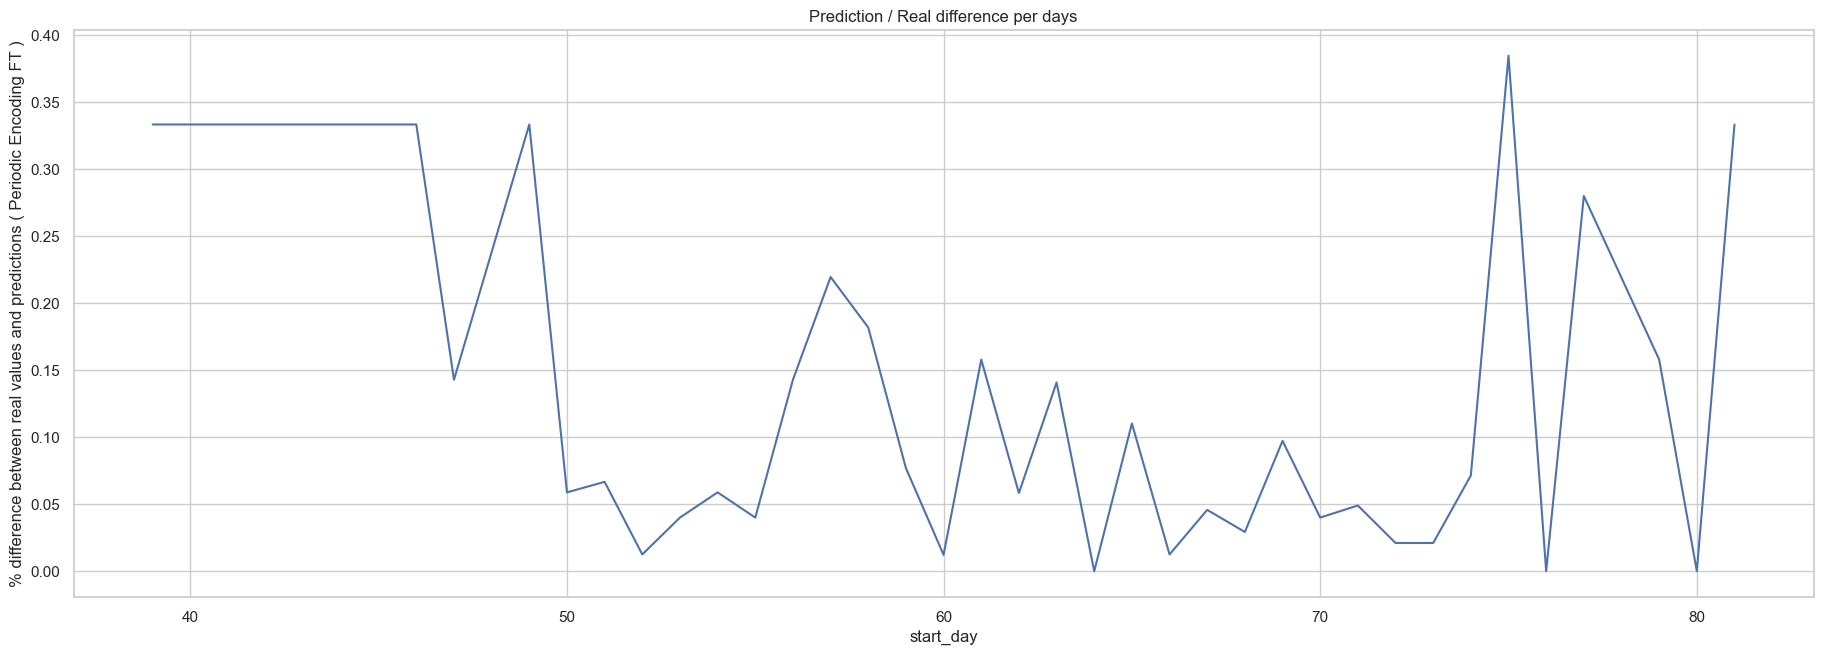

In [80]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

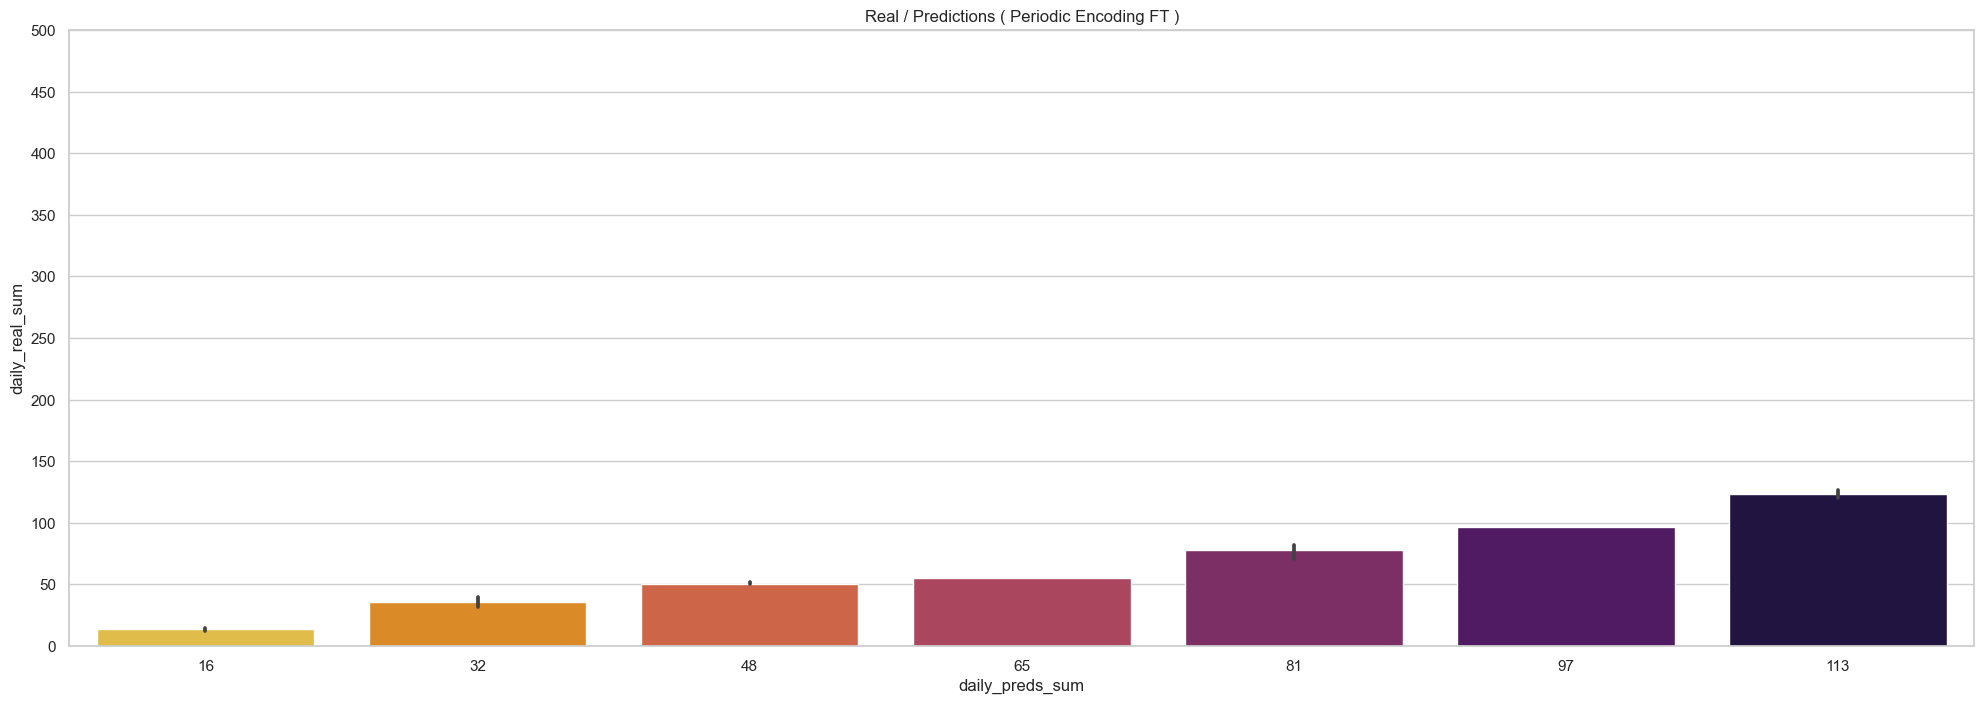

In [81]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

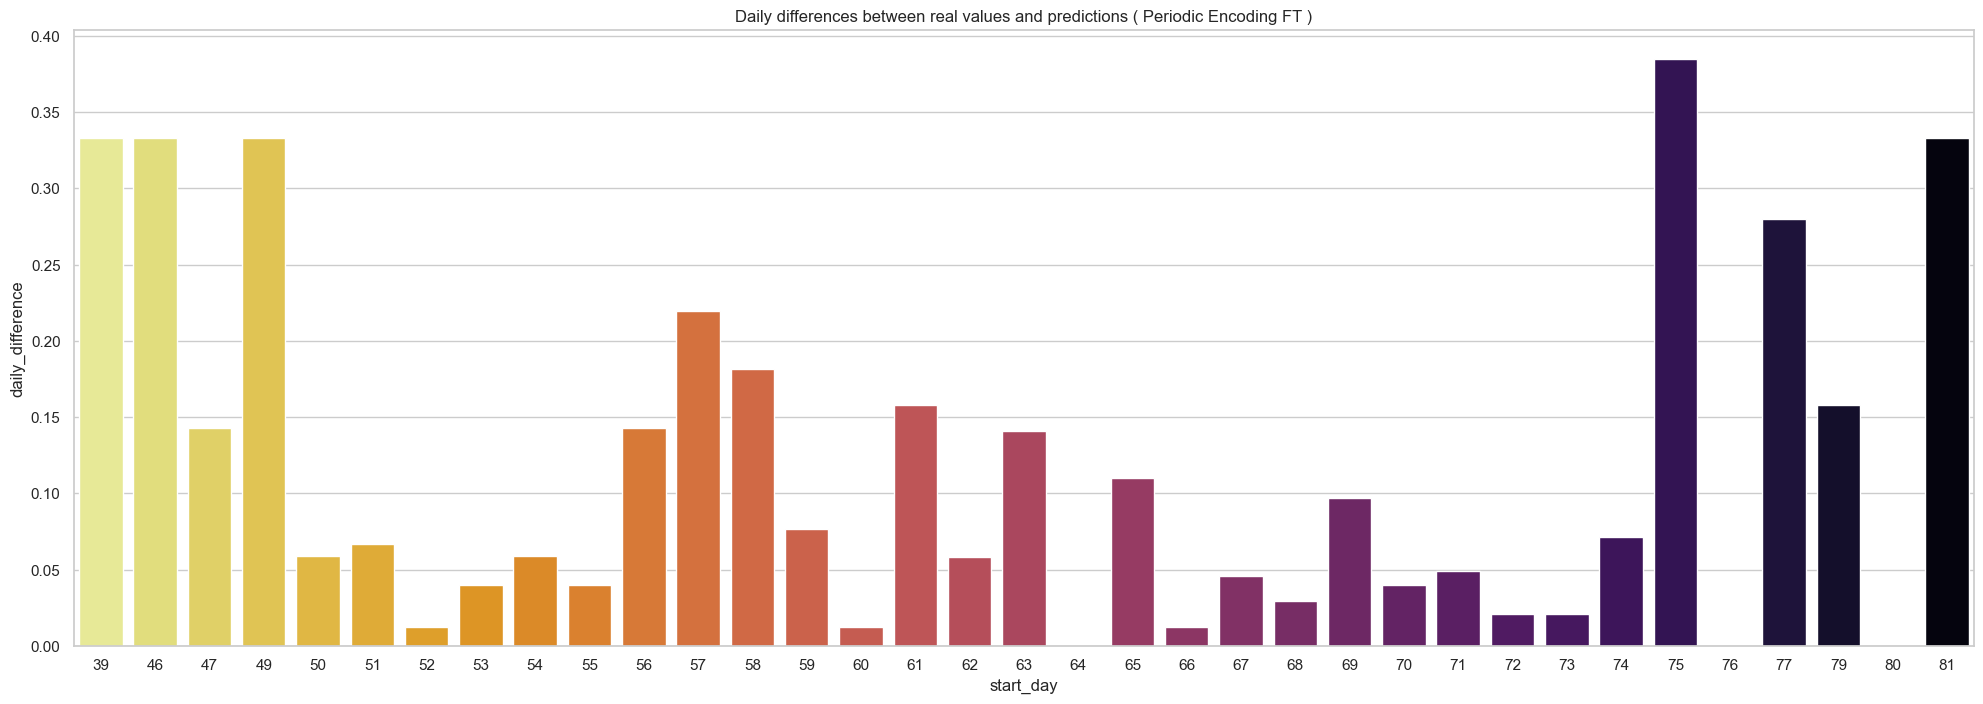

In [82]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [83]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-25 10:51:52,637] A new study created in memory with name: no-name-b181d4f4-c9ef-4995-b21a-591b8ccc6bb0


Epoch 1/150
2/2 [==============================] - 5s 781ms/step - loss: 209.5831 - output_loss: 209.5831 - output_rmse: 14.4770 - val_loss: 125.8046 - val_output_loss: 125.8046 - val_output_rmse: 11.2163
Epoch 2/150
2/2 [==============================] - 1s 326ms/step - loss: 147.5718 - output_loss: 147.5718 - output_rmse: 12.1479 - val_loss: 89.6019 - val_output_loss: 89.6019 - val_output_rmse: 9.4658
Epoch 3/150
2/2 [==============================] - 1s 316ms/step - loss: 115.5870 - output_loss: 115.5870 - output_rmse: 10.7511 - val_loss: 63.3753 - val_output_loss: 63.3753 - val_output_rmse: 7.9609
Epoch 4/150
2/2 [==============================] - 1s 316ms/step - loss: 91.8239 - output_loss: 91.8239 - output_rmse: 9.5825 - val_loss: 46.3551 - val_output_loss: 46.3551 - val_output_rmse: 6.8085
Epoch 5/150
2/2 [==============================] - 1s 319ms/step - loss: 74.2545 - output_loss: 74.2545 - output_rmse: 8.6171 - val_loss: 36.0318 - val_output_loss: 36.0318 - val_output_rmse: 

[I 2023-01-25 10:52:19,089] Trial 0 finished with value: 3.1738438415812653 and parameters: {'numerical_bins': 130, 'embedding_dim': 68, 'depth': 1, 'heads': 4, 'attn_dropout': 0.4034000624888541, 'ff_dropout': 0.4167168046623064}. Best is trial 0 with value: 3.1738438415812653.


Epoch 1/150
2/2 [==============================] - 8s 2s/step - loss: 236.0470 - output_loss: 236.0470 - output_rmse: 15.3638 - val_loss: 156.4532 - val_output_loss: 156.4532 - val_output_rmse: 12.5081
Epoch 2/150
2/2 [==============================] - 2s 1s/step - loss: 168.8173 - output_loss: 168.8173 - output_rmse: 12.9930 - val_loss: 123.8309 - val_output_loss: 123.8309 - val_output_rmse: 11.1279
Epoch 3/150
2/2 [==============================] - 3s 1s/step - loss: 137.4517 - output_loss: 137.4517 - output_rmse: 11.7240 - val_loss: 109.7016 - val_output_loss: 109.7016 - val_output_rmse: 10.4739
Epoch 4/150
2/2 [==============================] - 3s 1s/step - loss: 119.5517 - output_loss: 119.5517 - output_rmse: 10.9340 - val_loss: 99.6690 - val_output_loss: 99.6690 - val_output_rmse: 9.9834
Epoch 5/150
2/2 [==============================] - 2s 1s/step - loss: 106.7390 - output_loss: 106.7390 - output_rmse: 10.3315 - val_loss: 91.6517 - val_output_loss: 91.6517 - val_output_rmse: 9.5

[I 2023-01-25 10:55:16,704] Trial 1 finished with value: 3.171169034574152 and parameters: {'numerical_bins': 47, 'embedding_dim': 42, 'depth': 3, 'heads': 8, 'attn_dropout': 0.09031619498564508, 'ff_dropout': 0.30631288867527895}. Best is trial 1 with value: 3.171169034574152.


Epoch 1/150
2/2 [==============================] - 7s 1s/step - loss: 266.9211 - output_loss: 266.9211 - output_rmse: 16.3377 - val_loss: 230.1695 - val_output_loss: 230.1695 - val_output_rmse: 15.1713
Epoch 2/150
2/2 [==============================] - 1s 413ms/step - loss: 234.9002 - output_loss: 234.9002 - output_rmse: 15.3265 - val_loss: 211.1151 - val_output_loss: 211.1151 - val_output_rmse: 14.5298
Epoch 3/150
2/2 [==============================] - 1s 416ms/step - loss: 216.6426 - output_loss: 216.6426 - output_rmse: 14.7188 - val_loss: 198.9910 - val_output_loss: 198.9910 - val_output_rmse: 14.1064
Epoch 4/150
2/2 [==============================] - 1s 404ms/step - loss: 204.1340 - output_loss: 204.1340 - output_rmse: 14.2875 - val_loss: 191.5114 - val_output_loss: 191.5114 - val_output_rmse: 13.8388
Epoch 5/150
2/2 [==============================] - 1s 399ms/step - loss: 195.2590 - output_loss: 195.2590 - output_rmse: 13.9735 - val_loss: 185.0574 - val_output_loss: 185.0574 - val

[I 2023-01-25 10:57:22,250] Trial 2 finished with value: 2.5706568870809368 and parameters: {'numerical_bins': 88, 'embedding_dim': 17, 'depth': 6, 'heads': 3, 'attn_dropout': 0.23908850993829533, 'ff_dropout': 0.059687746830716204}. Best is trial 2 with value: 2.5706568870809368.


Epoch 1/150
2/2 [==============================] - 10s 2s/step - loss: 194.3822 - output_loss: 194.3822 - output_rmse: 13.9421 - val_loss: 71.4115 - val_output_loss: 71.4115 - val_output_rmse: 8.4505
Epoch 2/150
2/2 [==============================] - 4s 2s/step - loss: 66.2317 - output_loss: 66.2317 - output_rmse: 8.1383 - val_loss: 36.4821 - val_output_loss: 36.4821 - val_output_rmse: 6.0400
Epoch 3/150
2/2 [==============================] - 3s 2s/step - loss: 37.8584 - output_loss: 37.8584 - output_rmse: 6.1529 - val_loss: 26.9605 - val_output_loss: 26.9605 - val_output_rmse: 5.1923
Epoch 4/150
2/2 [==============================] - 3s 2s/step - loss: 28.3183 - output_loss: 28.3183 - output_rmse: 5.3215 - val_loss: 20.8866 - val_output_loss: 20.8866 - val_output_rmse: 4.5702
Epoch 5/150
2/2 [==============================] - 3s 2s/step - loss: 22.3537 - output_loss: 22.3537 - output_rmse: 4.7280 - val_loss: 16.7656 - val_output_loss: 16.7656 - val_output_rmse: 4.0946
Epoch 6/150
2/2 

[I 2023-01-25 11:05:01,289] Trial 3 finished with value: 2.129896940870696 and parameters: {'numerical_bins': 164, 'embedding_dim': 73, 'depth': 6, 'heads': 4, 'attn_dropout': 0.1218189780874388, 'ff_dropout': 0.06593689453030421}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 5s 1s/step - loss: 231.9535 - output_loss: 231.9535 - output_rmse: 15.2300 - val_loss: 123.5717 - val_output_loss: 123.5717 - val_output_rmse: 11.1163
Epoch 2/150
2/2 [==============================] - 1s 755ms/step - loss: 110.9953 - output_loss: 110.9953 - output_rmse: 10.5354 - val_loss: 68.1772 - val_output_loss: 68.1772 - val_output_rmse: 8.2570
Epoch 3/150
2/2 [==============================] - 1s 739ms/step - loss: 66.1563 - output_loss: 66.1563 - output_rmse: 8.1337 - val_loss: 49.3527 - val_output_loss: 49.3527 - val_output_rmse: 7.0251
Epoch 4/150
2/2 [==============================] - 1s 749ms/step - loss: 48.5826 - output_loss: 48.5826 - output_rmse: 6.9701 - val_loss: 36.4487 - val_output_loss: 36.4487 - val_output_rmse: 6.0373
Epoch 5/150
2/2 [==============================] - 1s 751ms/step - loss: 36.7811 - output_loss: 36.7811 - output_rmse: 6.0647 - val_loss: 28.8993 - val_output_loss: 28.8993 - val_output_rmse: 5.3758

[I 2023-01-25 11:07:52,543] Trial 4 finished with value: 2.1552017480019314 and parameters: {'numerical_bins': 46, 'embedding_dim': 65, 'depth': 2, 'heads': 6, 'attn_dropout': 0.2171336920160949, 'ff_dropout': 0.017382191543677428}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 6s 1s/step - loss: 184.8602 - output_loss: 184.8602 - output_rmse: 13.5963 - val_loss: 108.6282 - val_output_loss: 108.6282 - val_output_rmse: 10.4225
Epoch 2/150
2/2 [==============================] - 2s 953ms/step - loss: 104.2960 - output_loss: 104.2960 - output_rmse: 10.2125 - val_loss: 76.8967 - val_output_loss: 76.8967 - val_output_rmse: 8.7691
Epoch 3/150
2/2 [==============================] - 2s 945ms/step - loss: 75.0911 - output_loss: 75.0911 - output_rmse: 8.6655 - val_loss: 56.3918 - val_output_loss: 56.3918 - val_output_rmse: 7.5094
Epoch 4/150
2/2 [==============================] - 2s 946ms/step - loss: 56.2607 - output_loss: 56.2607 - output_rmse: 7.5007 - val_loss: 45.3129 - val_output_loss: 45.3129 - val_output_rmse: 6.7315
Epoch 5/150
2/2 [==============================] - 2s 948ms/step - loss: 46.4336 - output_loss: 46.4336 - output_rmse: 6.8142 - val_loss: 39.4123 - val_output_loss: 39.4123 - val_output_rmse: 6.2779

[I 2023-01-25 11:12:38,351] Trial 5 finished with value: 2.1720381011211782 and parameters: {'numerical_bins': 89, 'embedding_dim': 80, 'depth': 3, 'heads': 4, 'attn_dropout': 0.3822930958863149, 'ff_dropout': 0.02368950928287994}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 12s 4s/step - loss: 219.1662 - output_loss: 219.1662 - output_rmse: 14.8043 - val_loss: 123.5297 - val_output_loss: 123.5297 - val_output_rmse: 11.1144
Epoch 2/150
2/2 [==============================] - 6s 3s/step - loss: 117.5199 - output_loss: 117.5199 - output_rmse: 10.8407 - val_loss: 85.6309 - val_output_loss: 85.6309 - val_output_rmse: 9.2537
Epoch 3/150
2/2 [==============================] - 6s 3s/step - loss: 85.5647 - output_loss: 85.5647 - output_rmse: 9.2501 - val_loss: 71.2907 - val_output_loss: 71.2907 - val_output_rmse: 8.4434
Epoch 4/150
2/2 [==============================] - 6s 3s/step - loss: 72.7009 - output_loss: 72.7009 - output_rmse: 8.5265 - val_loss: 64.7726 - val_output_loss: 64.7726 - val_output_rmse: 8.0481
Epoch 5/150
2/2 [==============================] - 6s 3s/step - loss: 66.3644 - output_loss: 66.3644 - output_rmse: 8.1464 - val_loss: 60.0905 - val_output_loss: 60.0905 - val_output_rmse: 7.7518
Epoch 6/15

[I 2023-01-25 11:24:53,720] Trial 6 finished with value: 2.3431972305609365 and parameters: {'numerical_bins': 149, 'embedding_dim': 76, 'depth': 5, 'heads': 8, 'attn_dropout': 0.2950288671252217, 'ff_dropout': 0.05912542717623109}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 6s 1s/step - loss: 273.0891 - output_loss: 273.0891 - output_rmse: 16.5254 - val_loss: 232.5155 - val_output_loss: 232.5155 - val_output_rmse: 15.2485
Epoch 2/150
2/2 [==============================] - 1s 687ms/step - loss: 250.0282 - output_loss: 250.0282 - output_rmse: 15.8123 - val_loss: 207.3582 - val_output_loss: 207.3582 - val_output_rmse: 14.3999
Epoch 3/150
2/2 [==============================] - 1s 684ms/step - loss: 221.7131 - output_loss: 221.7131 - output_rmse: 14.8900 - val_loss: 188.7984 - val_output_loss: 188.7984 - val_output_rmse: 13.7404
Epoch 4/150
2/2 [==============================] - 1s 690ms/step - loss: 202.7093 - output_loss: 202.7093 - output_rmse: 14.2376 - val_loss: 175.5404 - val_output_loss: 175.5404 - val_output_rmse: 13.2492
Epoch 5/150
2/2 [==============================] - 1s 687ms/step - loss: 187.4106 - output_loss: 187.4106 - output_rmse: 13.6898 - val_loss: 164.2117 - val_output_loss: 164.2117 - val

[I 2023-01-25 11:27:05,613] Trial 7 finished with value: 3.1710530673651474 and parameters: {'numerical_bins': 147, 'embedding_dim': 42, 'depth': 5, 'heads': 3, 'attn_dropout': 0.15090691923763877, 'ff_dropout': 0.32773315195075053}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 7s 1s/step - loss: 234.1715 - output_loss: 234.1715 - output_rmse: 15.3027 - val_loss: 157.4074 - val_output_loss: 157.4074 - val_output_rmse: 12.5462
Epoch 2/150
2/2 [==============================] - 1s 503ms/step - loss: 160.6406 - output_loss: 160.6406 - output_rmse: 12.6744 - val_loss: 127.5074 - val_output_loss: 127.5074 - val_output_rmse: 11.2919
Epoch 3/150
2/2 [==============================] - 1s 497ms/step - loss: 133.0602 - output_loss: 133.0602 - output_rmse: 11.5352 - val_loss: 108.7524 - val_output_loss: 108.7524 - val_output_rmse: 10.4284
Epoch 4/150
2/2 [==============================] - 1s 493ms/step - loss: 113.1302 - output_loss: 113.1302 - output_rmse: 10.6363 - val_loss: 94.5557 - val_output_loss: 94.5557 - val_output_rmse: 9.7240
Epoch 5/150
2/2 [==============================] - 1s 495ms/step - loss: 98.4580 - output_loss: 98.4580 - output_rmse: 9.9226 - val_loss: 83.0961 - val_output_loss: 83.0961 - val_output_

[I 2023-01-25 11:29:14,220] Trial 8 finished with value: 2.383181467007048 and parameters: {'numerical_bins': 89, 'embedding_dim': 40, 'depth': 6, 'heads': 2, 'attn_dropout': 0.16334468132737506, 'ff_dropout': 0.11423872896213971}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 10s 3s/step - loss: 201.8367 - output_loss: 201.8367 - output_rmse: 14.2069 - val_loss: 109.7108 - val_output_loss: 109.7108 - val_output_rmse: 10.4743
Epoch 2/150
2/2 [==============================] - 4s 2s/step - loss: 101.8759 - output_loss: 101.8759 - output_rmse: 10.0934 - val_loss: 73.5169 - val_output_loss: 73.5169 - val_output_rmse: 8.5742
Epoch 3/150
2/2 [==============================] - 4s 2s/step - loss: 71.5826 - output_loss: 71.5826 - output_rmse: 8.4607 - val_loss: 60.4182 - val_output_loss: 60.4182 - val_output_rmse: 7.7729
Epoch 4/150
2/2 [==============================] - 4s 2s/step - loss: 60.6493 - output_loss: 60.6493 - output_rmse: 7.7878 - val_loss: 54.1415 - val_output_loss: 54.1415 - val_output_rmse: 7.3581
Epoch 5/150
2/2 [==============================] - 4s 2s/step - loss: 54.7532 - output_loss: 54.7532 - output_rmse: 7.3995 - val_loss: 49.8768 - val_output_loss: 49.8768 - val_output_rmse: 7.0623
Epoch 6/15

[I 2023-01-25 11:39:03,390] Trial 9 finished with value: 2.1855061510713085 and parameters: {'numerical_bins': 25, 'embedding_dim': 68, 'depth': 5, 'heads': 7, 'attn_dropout': 0.147345812037597, 'ff_dropout': 0.010812269741849678}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 9s 3s/step - loss: 159.3198 - output_loss: 159.3198 - output_rmse: 12.6222 - val_loss: 19.8475 - val_output_loss: 19.8475 - val_output_rmse: 4.4551
Epoch 2/150
2/2 [==============================] - 4s 2s/step - loss: 23.2433 - output_loss: 23.2433 - output_rmse: 4.8211 - val_loss: 7.2897 - val_output_loss: 7.2897 - val_output_rmse: 2.6999
Epoch 3/150
2/2 [==============================] - 4s 2s/step - loss: 8.6715 - output_loss: 8.6715 - output_rmse: 2.9447 - val_loss: 8.8519 - val_output_loss: 8.8519 - val_output_rmse: 2.9752
Epoch 4/150
2/2 [==============================] - 4s 2s/step - loss: 8.9153 - output_loss: 8.9153 - output_rmse: 2.9859 - val_loss: 9.9546 - val_output_loss: 9.9546 - val_output_rmse: 3.1551
Epoch 5/150
2/2 [==============================] - 4s 2s/step - loss: 9.4658 - output_loss: 9.4658 - output_rmse: 3.0766 - val_loss: 9.1674 - val_output_loss: 9.1674 - val_output_rmse: 3.0278
Epoch 6/150
2/2 [==============

[I 2023-01-25 11:44:31,004] Trial 10 finished with value: 2.2064968652635715 and parameters: {'numerical_bins': 198, 'embedding_dim': 99, 'depth': 4, 'heads': 5, 'attn_dropout': 0.0285701726007776, 'ff_dropout': 0.20346619292507645}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 4s 944ms/step - loss: 236.8330 - output_loss: 236.8330 - output_rmse: 15.3894 - val_loss: 145.4833 - val_output_loss: 145.4833 - val_output_rmse: 12.0616
Epoch 2/150
2/2 [==============================] - 1s 561ms/step - loss: 145.3775 - output_loss: 145.3775 - output_rmse: 12.0573 - val_loss: 103.1782 - val_output_loss: 103.1782 - val_output_rmse: 10.1577
Epoch 3/150
2/2 [==============================] - 1s 548ms/step - loss: 111.2881 - output_loss: 111.2881 - output_rmse: 10.5493 - val_loss: 82.1523 - val_output_loss: 82.1523 - val_output_rmse: 9.0638
Epoch 4/150
2/2 [==============================] - 1s 585ms/step - loss: 90.0370 - output_loss: 90.0370 - output_rmse: 9.4888 - val_loss: 68.1323 - val_output_loss: 68.1323 - val_output_rmse: 8.2542
Epoch 5/150
2/2 [==============================] - 1s 569ms/step - loss: 74.8920 - output_loss: 74.8920 - output_rmse: 8.6540 - val_loss: 55.9497 - val_output_loss: 55.9497 - val_output_rms

[I 2023-01-25 11:46:11,697] Trial 11 finished with value: 2.3341786837516034 and parameters: {'numerical_bins': 200, 'embedding_dim': 92, 'depth': 1, 'heads': 6, 'attn_dropout': 0.2583490748620869, 'ff_dropout': 0.1405594446501253}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 5s 1s/step - loss: 199.8142 - output_loss: 199.8142 - output_rmse: 14.1356 - val_loss: 98.2489 - val_output_loss: 98.2489 - val_output_rmse: 9.9121
Epoch 2/150
2/2 [==============================] - 1s 708ms/step - loss: 92.8316 - output_loss: 92.8316 - output_rmse: 9.6349 - val_loss: 49.8049 - val_output_loss: 49.8049 - val_output_rmse: 7.0573
Epoch 3/150
2/2 [==============================] - 1s 713ms/step - loss: 52.3238 - output_loss: 52.3238 - output_rmse: 7.2335 - val_loss: 28.2467 - val_output_loss: 28.2467 - val_output_rmse: 5.3148
Epoch 4/150
2/2 [==============================] - 1s 742ms/step - loss: 31.9450 - output_loss: 31.9450 - output_rmse: 5.6520 - val_loss: 17.9379 - val_output_loss: 17.9379 - val_output_rmse: 4.2353
Epoch 5/150
2/2 [==============================] - 2s 762ms/step - loss: 21.6627 - output_loss: 21.6627 - output_rmse: 4.6543 - val_loss: 13.1448 - val_output_loss: 13.1448 - val_output_rmse: 3.6256
Epoch

[I 2023-01-25 11:48:13,123] Trial 12 finished with value: 2.2690674441649747 and parameters: {'numerical_bins': 56, 'embedding_dim': 58, 'depth': 2, 'heads': 6, 'attn_dropout': 0.0016703529194643518, 'ff_dropout': 0.15263828362842918}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 4s 995ms/step - loss: 250.9243 - output_loss: 250.9243 - output_rmse: 15.8406 - val_loss: 183.9617 - val_output_loss: 183.9617 - val_output_rmse: 13.5632
Epoch 2/150
2/2 [==============================] - 1s 547ms/step - loss: 179.7691 - output_loss: 179.7691 - output_rmse: 13.4078 - val_loss: 147.0528 - val_output_loss: 147.0528 - val_output_rmse: 12.1265
Epoch 3/150
2/2 [==============================] - 1s 554ms/step - loss: 146.1474 - output_loss: 146.1474 - output_rmse: 12.0891 - val_loss: 123.2620 - val_output_loss: 123.2620 - val_output_rmse: 11.1023
Epoch 4/150
2/2 [==============================] - 1s 555ms/step - loss: 122.7799 - output_loss: 122.7799 - output_rmse: 11.0806 - val_loss: 107.8126 - val_output_loss: 107.8126 - val_output_rmse: 10.3833
Epoch 5/150
2/2 [==============================] - 1s 567ms/step - loss: 109.7261 - output_loss: 109.7261 - output_rmse: 10.4750 - val_loss: 98.6135 - val_output_loss: 98.6135 - va

[I 2023-01-25 11:51:08,695] Trial 13 finished with value: 2.152051568130879 and parameters: {'numerical_bins': 169, 'embedding_dim': 54, 'depth': 2, 'heads': 5, 'attn_dropout': 0.4990883084703247, 'ff_dropout': 0.0050820121875345126}. Best is trial 3 with value: 2.129896940870696.


Epoch 1/150
2/2 [==============================] - 4s 695ms/step - loss: 260.2071 - output_loss: 260.2071 - output_rmse: 16.1309 - val_loss: 207.3448 - val_output_loss: 207.3448 - val_output_rmse: 14.3995
Epoch 2/150
2/2 [==============================] - 1s 264ms/step - loss: 215.8269 - output_loss: 215.8269 - output_rmse: 14.6910 - val_loss: 189.5490 - val_output_loss: 189.5490 - val_output_rmse: 13.7677
Epoch 3/150
2/2 [==============================] - 1s 256ms/step - loss: 195.2954 - output_loss: 195.2954 - output_rmse: 13.9748 - val_loss: 175.4028 - val_output_loss: 175.4028 - val_output_rmse: 13.2440
Epoch 4/150
2/2 [==============================] - 1s 267ms/step - loss: 179.0711 - output_loss: 179.0711 - output_rmse: 13.3817 - val_loss: 161.0756 - val_output_loss: 161.0756 - val_output_rmse: 12.6916
Epoch 5/150
2/2 [==============================] - 1s 258ms/step - loss: 165.4142 - output_loss: 165.4142 - output_rmse: 12.8613 - val_loss: 149.6074 - val_output_loss: 149.6074 - 

[I 2023-01-25 11:52:05,188] Trial 14 finished with value: 3.170829571639934 and parameters: {'numerical_bins': 168, 'embedding_dim': 22, 'depth': 2, 'heads': 5, 'attn_dropout': 0.4547791143612096, 'ff_dropout': 0.09093829161445885}. Best is trial 3 with value: 2.129896940870696.


Number of finished trials: 15
Best trial: {'numerical_bins': 164, 'embedding_dim': 73, 'depth': 6, 'heads': 4, 'attn_dropout': 0.1218189780874388, 'ff_dropout': 0.06593689453030421}


In [84]:
study.best_trial.params

{'numerical_bins': 164,
 'embedding_dim': 73,
 'depth': 6,
 'heads': 4,
 'attn_dropout': 0.1218189780874388,
 'ff_dropout': 0.06593689453030421}

In [85]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=72,
    embedding_dim=72,
    depth=5,
    heads=4,
    attn_dropout= 0.3554,
    ff_dropout= 0.4934,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 9s 2s/step - loss: 221.1828 - output_loss: 221.1828 - output_rmse: 14.8722 - val_loss: 83.6540 - val_output_loss: 83.6540 - val_output_rmse: 9.1463
Epoch 2/250
2/2 [==============================] - 3s 1s/step - loss: 106.2283 - output_loss: 106.2283 - output_rmse: 10.3067 - val_loss: 41.7547 - val_output_loss: 41.7547 - val_output_rmse: 6.4618
Epoch 3/250
2/2 [==============================] - 3s 1s/step - loss: 55.6866 - output_loss: 55.6866 - output_rmse: 7.4623 - val_loss: 24.3600 - val_output_loss: 24.3600 - val_output_rmse: 4.9356
Epoch 4/250
2/2 [==============================] - 3s 1s/step - loss: 33.5263 - output_loss: 33.5263 - output_rmse: 5.7902 - val_loss: 17.2439 - val_output_loss: 17.2439 - val_output_rmse: 4.1526
Epoch 5/250
2/2 [==============================] - 3s 1s/step - loss: 22.7226 - output_loss: 22.7226 - output_rmse: 4.7668 - val_loss: 13.6731 - val_output_loss: 13.6731 - val_output_rmse: 3.6977
Epoch 6/250
2/

In [86]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 815ms/step


In [87]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 167ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

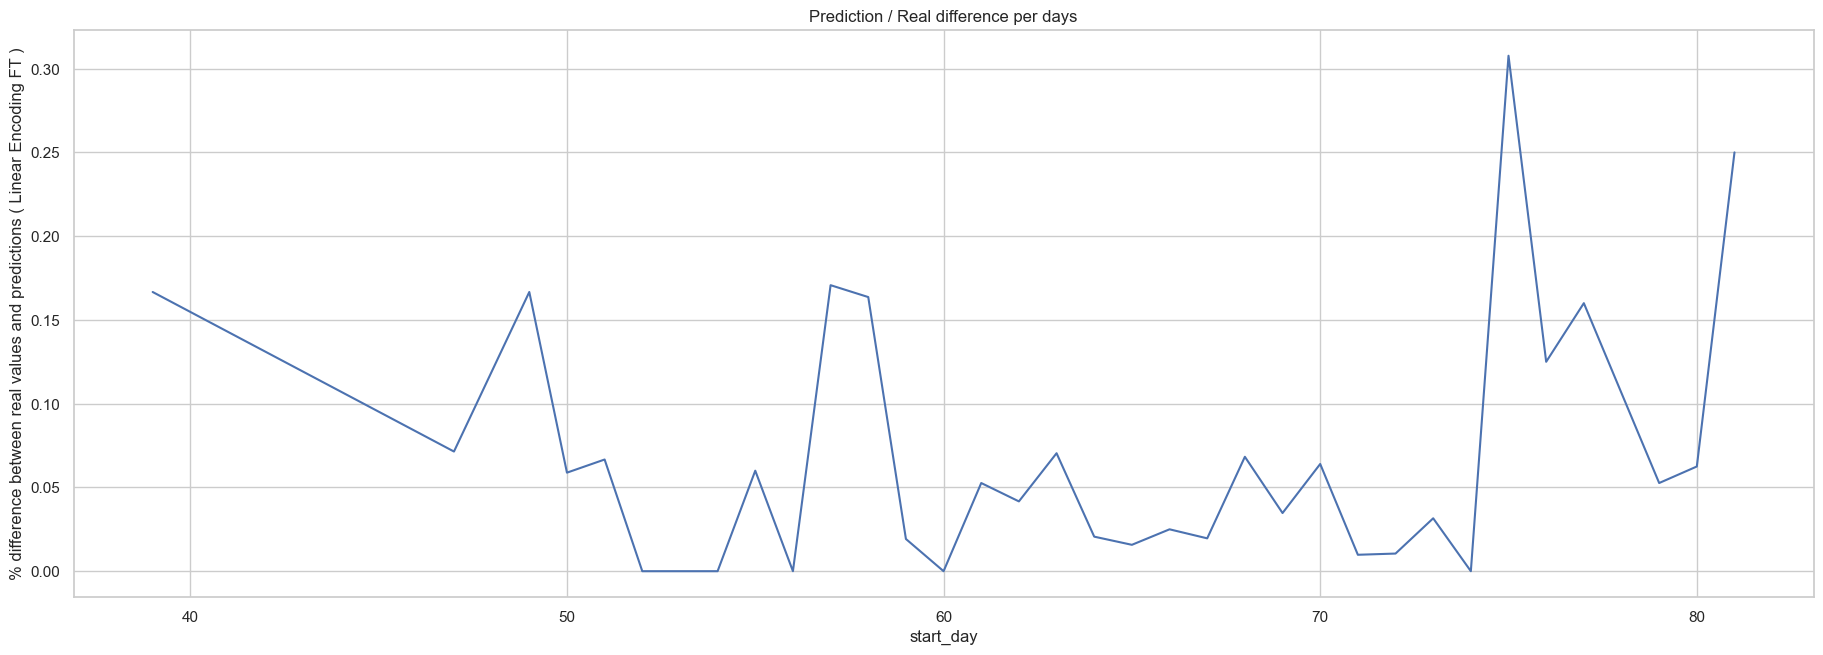

In [88]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

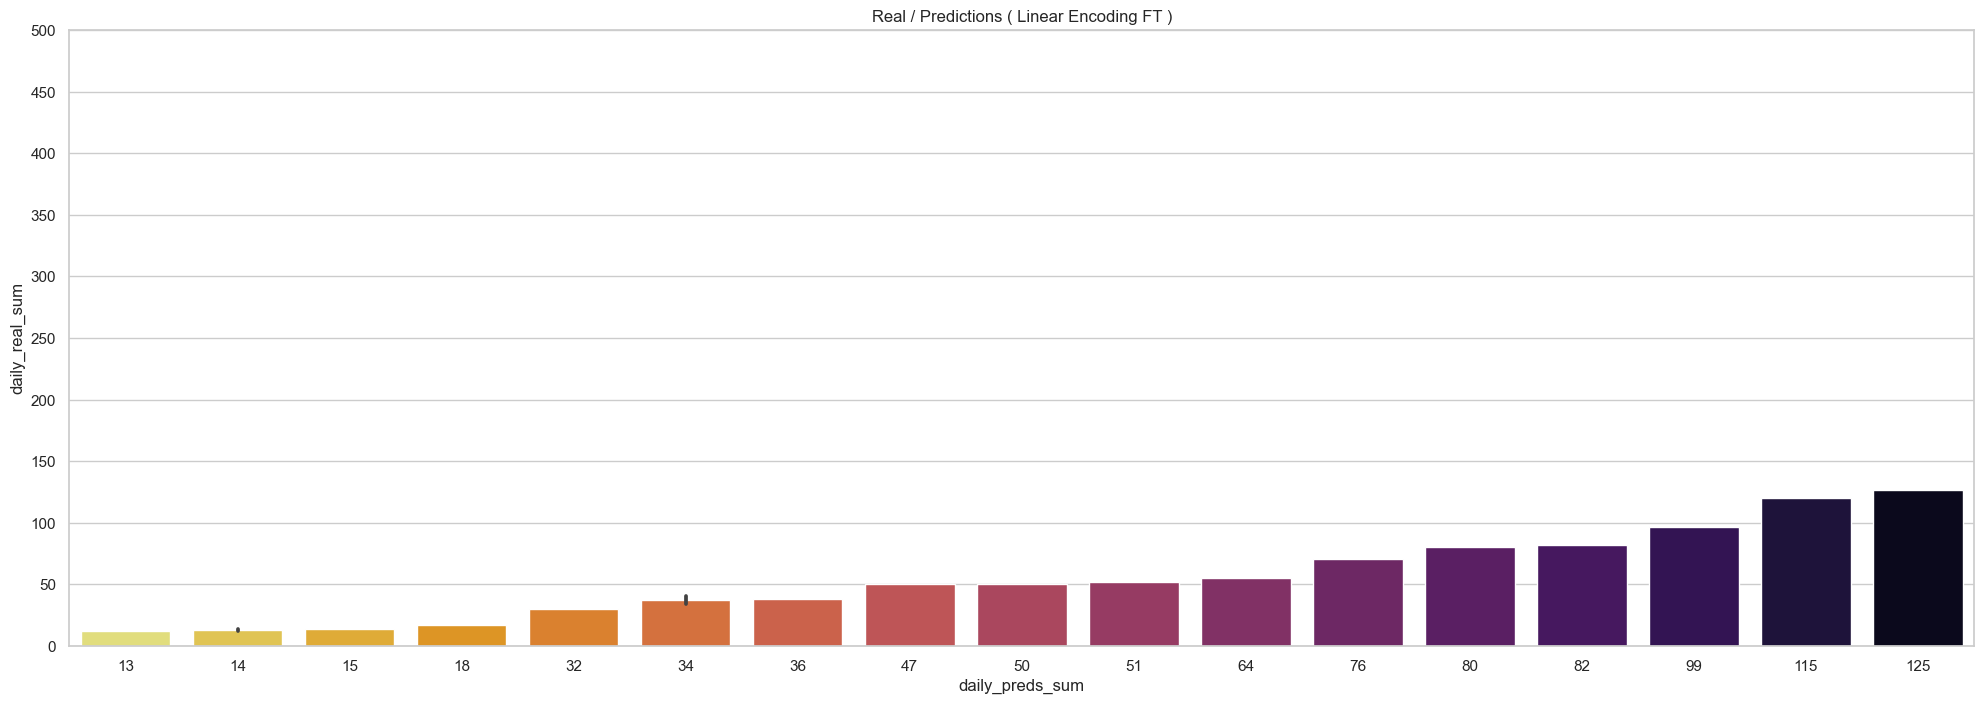

In [89]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

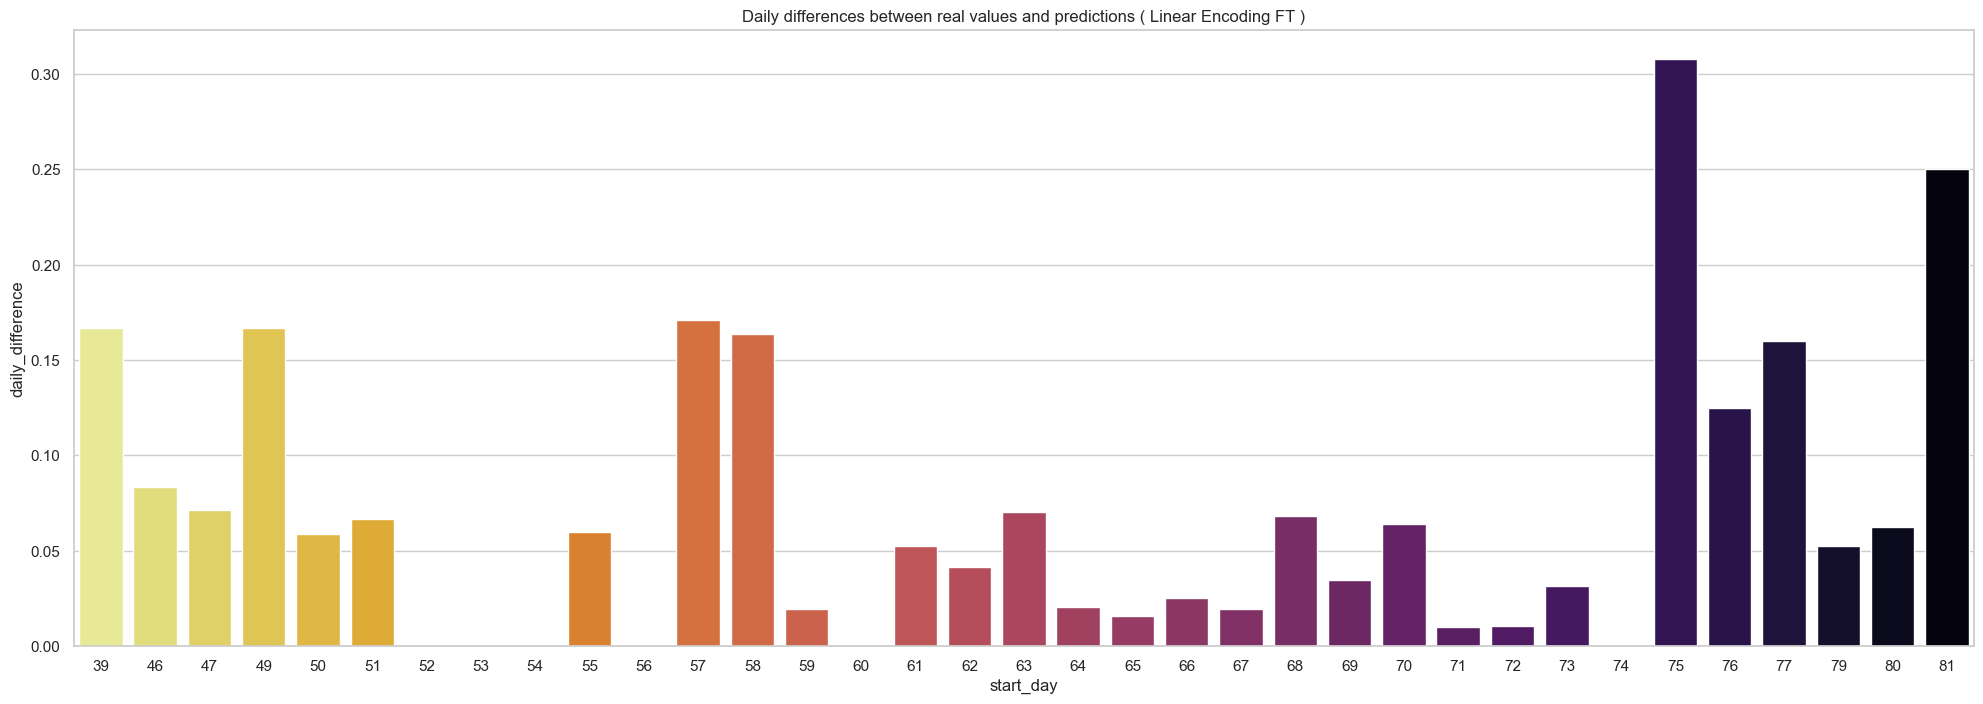

In [90]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### LightGBM

In [91]:
df = data.copy()
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")
df = df.loc[:,~df.columns.duplicated()].copy()

In [92]:
CATEGORICAL_FEATURES = ["patient's most seen condition",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Alkaline_phosphatase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's most seen observation",
 "patient's most used medication",
 "patient's most usage reason",
 "patient's most used device",
 "patient's most seen allergy"]

In [93]:
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

In [94]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb


model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

AttributeError: dlsym(0x335d43510, LGBM_DumpParamAliases): symbol not found

In [ ]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER",
                                           "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)

In [ ]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
param_comb = 6

kf = StratifiedKFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)

In [ ]:
df.icu_start = pd.to_datetime(df.icu_start)
test.icu_start = pd.to_datetime(test.icu_start)

df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

In [ ]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

In [ ]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

In [ ]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 8))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

### Our results were like this :

In [ ]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [ ]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
